In [1]:
#ONLY RUN IF USING TORCH

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
torch.cuda.empty_cache() 

In [3]:
#ONLY RUN IF USING TORCH

from tape import ProteinBertModel, TAPETokenizer
model = ProteinBertModel.from_pretrained('bert-base')
modelTAPE = model.to(device)
tokenizerTAPE = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

modelTAPE.half()  # convert to half precision
for layer in modelTAPE.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.float()

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [2]:
def parse_fasta (lines):
    descs = []
    seqs = []
    data = ''
    for line in lines:
        if line.startswith('>'):
            if data:   # have collected a sequence, push to seqs
                seqs.append(data)
                data = ''
            descs.append(line[1:])  # Trim '>' from beginning
        else:
            data += line.rstrip('\r\n')
    # there will be yet one more to push when we run out
    seqs.append(data)
    return descs, seqs

In [3]:
def get_performance_vals(preds, classes):
    #0 is negative, 1 is positive
    a = np.array(preds) #Predictions
    b = classes #actual outcomes / classes
    #print("Predicted and actual classes\n")
    #print(classes)
    #print(a)
    tp = np.sum(np.multiply(a==1, b==1)) #TP
    fp = np.sum(np.multiply(a==1, b==0)) #FP
    tn = np.sum(np.multiply(a==0, b==0)) #TN
    fn = np.sum(np.multiply(a==0, b==1)) #FN

    tp = int(tp)
    fp = int(fp)
    tn = int(tn)
    fn = int(fn)

    print("True positive: %d, false positive: %d, true negative: %d, false negative: %d\n" %(tp,fp,tn,fn))

    mcc = (tp*tn-fp*fn)/(np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fscore = 2*precision*recall/(precision+recall)
    accuracy = np.sum(a==b)/len(classes)

    print("%s: %2f" % ('MCC', mcc))
    print("%s: %.2f%%" % ('Accuracy', 100*accuracy))
    print("%s: %.2f" % ('F1 score', fscore))
    print("%s: %.2f" % ('Precision', precision))
    print("%s: %.2f" % ('Recall', recall))

    #return mcc, precision, recall, fscore, accuracy

In [4]:
path = "./" + "pos_seqs_reduced" + ".pickle"
array_file = open(path, 'rb')
pos = pickle.load(array_file)
array_file.close()

len(pos)

2361

In [5]:
path = "./" + "pos_labels_reduced" + ".pickle"
array_file = open(path, 'rb')
pos_labels = pickle.load(array_file)
array_file.close()
len(pos_labels)

2361

In [6]:
handle = open("./cullpdb_pc20_res1.6_R0.25_d200625_chains3684_20200722.fasta", 'r')
descs, neg = parse_fasta(handle.read().split('\n'))

In [7]:
pdb = [d[:4] for d in descs]

In [8]:
dirpath = '../StructuralDataCreating/structures'
filist = os.listdir(dirpath)
flist = [s for s in filist if s.startswith('PDBpos') == True]
pos_pdbs = []
for f in flist:
    handle = open(os.path.join(dirpath, f), 'r')
    lines = handle.readlines()
    for line in lines:
        pos_pdbs.append(line.strip().split(' ')[0])

In [9]:
idx = []
name = []
i = 0
for p in pdb:
    if p in pos_pdbs:
        idx.append(i)
        name.append(p)
    i = i + 1

In [10]:
print(idx)
print(name)

[1939, 2345, 3196, 3305]
['6MYI', '1PP0', '4WDC', '3WZ3']


In [11]:
idx.reverse()

In [12]:
len(neg)

3679

In [13]:
print(idx)
for ix in idx:
    neg.pop(ix)

[3305, 3196, 2345, 1939]


In [14]:
neg_size = len(neg)
neg_size

3675

In [15]:
neg_labels = ['negative']*neg_size
len(neg_labels)

3675

In [16]:
data = pos + neg
labels = pos_labels + neg_labels

from sklearn.model_selection import train_test_split
train, dev, train_labels, validation_labels = train_test_split(
    data,
    labels,
    test_size = 0.2,
    random_state=1,
    stratify=labels)

#can jump to Method 3 from here

In [20]:
from collections import Counter

print(Counter(train_labels))
print(Counter(validation_labels))

Counter({'negative': 2939, 'PF12261_t_hemolysin_full_length_sequences.fasta': 238, 'PF03318_etx_mtx2_full_length_sequences.fasta': 233, 'PF01289_thiol_cytolysin_full_length_sequences.fasta': 164, 'PF06369_anemone_cytotox_full_length_sequences.fasta': 149, 'PF06355_aegerolysin_full_length_sequences.fasta': 148, 'PF11393_T4BSS_dotI_icml_full_length_sequences.fasta': 133, 'PF00087_toxin_tolip_full_length_sequences.fasta': 122, 'PF03945_Endotoxin_N_full_length_sequences.fasta': 109, 'PF01117_aerolysin_full_length_sequences.fasta': 104, 'PF07367_fb_lectin_full_length_sequences.fasta': 86, 'PF01338_Bac_thur_toxin_full_length_sequences.fasta': 50, 'PF07968_leukocidin_full_length_sequences.fasta': 40, 'PF18063_BB_PF_full_length_sequences.fasta': 38, 'PF06109_hlye_full_length_sequences.fasta': 37, 'PF05802_espb_full_length_sequences.fasta': 32, 'PF00555_Endotoxin_M_uniprot.fasta': 31, 'PF12920_tcda_tcdb_pore_full_length_sequences.fasta': 30, 'PF11565_porb_full_length_sequences.fasta': 24, 'PF01

## Loading the data

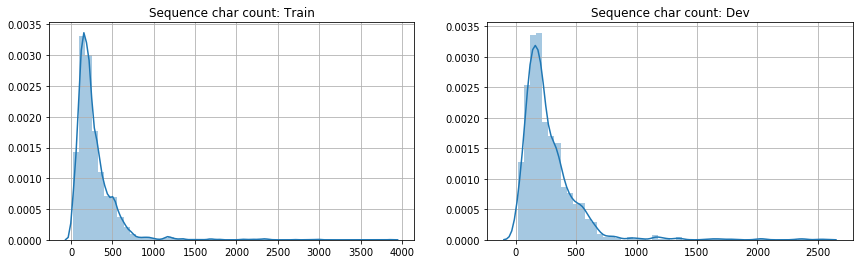

In [18]:
# Length of sequence in train data.
trainlen= [len(x) for x in train]
devlen= [len(x) for x in dev]

def plot_seq_count(lengths, data_name):
    seaborn.distplot(lengths)
    plt.title(f'Sequence char count: {data_name}')
    plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(trainlen, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(devlen, 'Dev')

plt.subplots_adjust(right=3.0)
plt.show()

In [19]:
print(max(trainlen))
print(max(devlen))

3862
2533


In [41]:
vocab_size = 21
max_length = 2000 #modified to 2000 as asked 
trunc_type = "post"
padding_type = "post"

trainTAPE = [tokenizerTAPE.encode(w.upper()) for w in train]
valTAPE = [tokenizerTAPE.encode(w.upper()) for w in dev]

In [42]:
trainTAPE = [np.array(t[:max_length]) for t in trainTAPE]
valTAPE = [np.array(t[:max_length]) for t in valTAPE]

trainTAPE = [torch.from_numpy(t) for t in trainTAPE]
valTAPE = [torch.from_numpy(t) for t in valTAPE]

In [43]:
TAPEtrain = torch.nn.utils.rnn.pad_sequence(trainTAPE, batch_first=False)
TAPEvalidation = torch.nn.utils.rnn.pad_sequence(valTAPE, batch_first=False)

In [44]:
TAPEtrain = torch.transpose(TAPEtrain,0,1)
TAPEvalidation = torch.transpose(TAPEvalidation,0,1)

In [45]:
TAPEvalidation.size()

torch.Size([1208, 2000])

In [46]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
batch_size = 1

dataloader_train = DataLoader(
    TAPEtrain,
    batch_size=batch_size
)

dataloader_validation = DataLoader(
    TAPEvalidation,
    batch_size=batch_size
)

In [48]:
#del pos, neg, data, labels, neg_labels, pos_labels, trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
#del pos, neg, data, labels, neg_labels, pos_labels, valTAPE, TAPEvalidation
del trainTAPE, valTAPE, TAPEtrain, TAPEvalidation
gc.collect()

28

In [49]:
torch.cuda.empty_cache() 

In [50]:
gc.collect()

40

In [ ]:
TAPEncoded_train = []

#iternum = 0
with torch.no_grad():
    for batch in tqdm(dataloader_train):
        b = batch.to(torch.long)
        output = modelTAPE(b.to(device))[1]
        TAPEncoded_train.append(output.cpu().detach().numpy())
        torch.cuda.empty_cache() 
        del b, output
        gc.collect()
#         if iternum%100 == 0:
#             print(iternum)
#         iternum = iternum + 1

In [39]:
path = "./" + "TAPEncoded_train_pooled" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_train, output)
output.close()

In [32]:
TAPEncoded_val = []

#iternum = 0
for batch in tqdm(dataloader_validation):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[1]
    TAPEncoded_val.append(output.cpu().detach().numpy())
    torch.cuda.empty_cache() 
    del b, output
    gc.collect()
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [33]:
path = "./" + "TAPEncoded_val_pooled" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_val, output)
output.close()

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((4828,), (1208,))

In [35]:
path = "./" + "train_labels" + ".pickle"
output = open(path, 'w+b')
pickle.dump(train_labels, output)
output.close()

path = "./" + "validation_labels" + ".pickle"
output = open(path, 'w+b')
pickle.dump(validation_labels, output)
output.close()

In [36]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'PF00087_toxin_tolip_full_length_sequences.fasta', 1: 'PF00555_Endotoxin_M_uniprot.fasta', 2: 'PF01024_colicin_full_length_sequences.fasta', 3: 'PF01117_aerolysin_full_length_sequences.fasta', 4: 'PF01289_thiol_cytolysin_full_length_sequences.fasta', 5: 'PF01338_Bac_thur_toxin_full_length_sequences.fasta', 6: 'PF01823_macpf_uniprot.fasta', 7: 'PF02382_rtx_full_length_sequences.fasta', 8: 'PF03318_etx_mtx2_full_length_sequences.fasta', 9: 'PF03505_clenterotox_full_length_sequences.fasta', 10: 'PF03944_Endotoxin_C_uniprot.fasta', 11: 'PF03945_Endotoxin_N_full_length_sequences.fasta', 12: 'PF04598_gasdermin_uniprot.fasta', 13: 'PF04877_harpin_full_length_sequences.fasta', 14: 'PF05802_espb_full_length_sequences.fasta', 15: 'PF06109_hlye_full_length_sequences.fasta', 16: 'PF06355_aegerolysin_full_length_sequences.fasta', 17: 'PF06369_anemone_cytotox_full_length_sequences.fasta', 18: 'PF07367_fb_lectin_full_length_sequences.fasta', 19: 'PF07968_leukocidin_full_length_sequences.fasta', 2

In [38]:
#del TAPEncoded_train, TAPEncoded_val
del TAPEncoded_val
gc.collect()
torch.cuda.empty_cache() 

In [51]:
#now getting the full embedding for all amino acid, not the pooled one
TAPEncoded_train = []
#iternum = 0
for batch in tqdm(dataloader_train):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_train.append(output.cpu().detach().numpy())
    torch.cuda.empty_cache() 
    del b, output
    gc.collect()
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [52]:
path = "./" + "TAPEncoded_train" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_train, output)
output.close()

In [53]:
del TAPEncoded_train
gc.collect()
torch.cuda.empty_cache() 

In [54]:
TAPEncoded_val = []
#iternum = 0
for batch in tqdm(dataloader_validation):
    b = batch.to(torch.long)
    output = modelTAPE(b.to(device))[0]
    TAPEncoded_val.append(output.cpu().detach().numpy())
    torch.cuda.empty_cache() 
    del b, output
    gc.collect()
#     if iternum%100 == 0:
#         print(iternum)
#     iternum = iternum + 1

In [55]:
path = "./" + "TAPEncoded_val" + ".pickle"
output = open(path, 'w+b')
pickle.dump(TAPEncoded_val, output)
output.close()

In [ ]:
#Method0 - Baseline, first nearest neighbour in terms of Levenshtein distance

In [17]:
path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

In [18]:
print(len(train))
print(len(dev))
print(len(train_labels))
print(len(validation_labels))

4828
1208
4828
1208


In [19]:
mask = (validation_labels == 27) #27 is negative

y_true = validation_labels
y_true[~mask] = 1
y_true[mask] = 0

In [20]:
validation_labels

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [21]:
mask = (train_labels == 27) #27 is negative

y_true = train_labels
y_true[~mask] = 1
y_true[mask] = 0

In [22]:
train_labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [23]:
import Levenshtein
from tqdm import tqdm

dist_arr = np.ones([len(dev), len(train)])*500

for i in tqdm(range(len(dev))):
    for j in range(len(train)):
        dist_arr[i,j] = Levenshtein.distance(dev[i], train[j])

100%|██████████████████████████████████████████████████████████████████████████████| 1208/1208 [10:09<00:00,  1.98it/s]


In [24]:
np.amin(dist_arr, 1)

array([384., 445.,  63., ..., 286.,  48., 112.])

In [25]:
np.argmin(dist_arr, 1)

array([2673, 3439, 4275, ..., 2378, 1122, 2673], dtype=int64)

In [26]:
preds = train_labels[np.argmin(dist_arr, 1)]

In [27]:
get_performance_vals(preds, validation_labels)

True positive: 438, false positive: 100, true negative: 636, false negative: 34

MCC: 0.777606
Accuracy: 88.91%
F1 score: 0.87
Precision: 0.81
Recall: 0.93


In [ ]:
#METHOD 1

In [ ]:
#STARTING HERE

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [3]:
path = "./" + "TAPEncoded_train_pooled" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val_pooled" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

In [4]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)

In [5]:
numclass = max(train_labels) + 1

In [50]:
input_x = tf.keras.layers.Input(shape=768) #768 is the embedding dimension
out = tf.keras.layers.Dense(numclass, activation="softmax")(input_x) 
model = tf.keras.Model(inputs=input_x, outputs=out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                22301     
Total params: 22,301
Trainable params: 22,301
Non-trainable params: 0
_________________________________________________________________


In [51]:
TAPEncoded_train = np.array(TAPEncoded_train)

In [52]:
TAPEncoded_train = TAPEncoded_train.reshape(-1,768)

In [53]:
TAPEncoded_val = np.array(TAPEncoded_val)

In [54]:
TAPEncoded_val = TAPEncoded_val.reshape(-1,768)

In [55]:
history = model.fit(TAPEncoded_train, train_labels, epochs=100, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/100
151/151 - 0s - loss: 1.7106 - accuracy: 0.5955 - val_loss: 1.5373 - val_accuracy: 0.6126
Epoch 2/100
151/151 - 0s - loss: 1.4709 - accuracy: 0.6137 - val_loss: 1.4138 - val_accuracy: 0.6142
Epoch 3/100
151/151 - 0s - loss: 1.3753 - accuracy: 0.6152 - val_loss: 1.3405 - val_accuracy: 0.6192
Epoch 4/100
151/151 - 0s - loss: 1.2974 - accuracy: 0.6251 - val_loss: 1.2953 - val_accuracy: 0.6465
Epoch 5/100
151/151 - 0s - loss: 1.2457 - accuracy: 0.6355 - val_loss: 1.2438 - val_accuracy: 0.6457
Epoch 6/100
151/151 - 0s - loss: 1.2032 - accuracy: 0.6498 - val_loss: 1.2003 - val_accuracy: 0.6498
Epoch 7/100
151/151 - 0s - loss: 1.1625 - accuracy: 0.6578 - val_loss: 1.1684 - val_accuracy: 0.6598
Epoch 8/100
151/151 - 0s - loss: 1.1310 - accuracy: 0.6690 - val_loss: 1.1446 - val_accuracy: 0.6755
Epoch 9/100
151/151 - 0s - loss: 1.1015 - accuracy: 0.6738 - val_loss: 1.1234 - val_accuracy: 0.6639
Epoch 10/100
151/151 - 0s - loss: 1.0789 - accuracy: 0.6839 - val_loss: 1.0921 - val_accura

In [56]:
preds = model.predict(TAPEncoded_val)

mask = (validation_labels == 27) #27 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 27)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [57]:
get_performance_vals(y_pred, y_true)

True positive: 265, false positive: 39, true negative: 697, false negative: 207

MCC: 0.571661
Accuracy: 79.64%
F1 score: 0.68
Precision: 0.87
Recall: 0.56


In [58]:
#METHOD 2

In [59]:
#STARTING HERE

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [2]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import gc
import sklearn
import pickle

In [3]:
path = "./" + "TAPEncoded_train" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

path = "./" + "train_labels" + ".pickle"
array_file = open(path, 'rb')
train_labels = pickle.load(array_file)
array_file.close()

path = "./" + "validation_labels" + ".pickle"
array_file = open(path, 'rb')
validation_labels = pickle.load(array_file)
array_file.close()

TAPEncoded_train = np.array(TAPEncoded_train)
TAPEncoded_train = np.squeeze(TAPEncoded_train)

TAPEncoded_val = np.array(TAPEncoded_val)
TAPEncoded_val = np.squeeze(TAPEncoded_val)

numclass = max(train_labels) + 1

In [4]:
gc.collect()

20

In [5]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [6]:
# batch_size = 8
# n_timesteps = 400
# n_features = 768
# input_x = tf.keras.layers.Input(shape=(n_timesteps,n_features))
# bi_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, batch_input_shape=(batch_size, n_timesteps, n_features), 
#                                                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             recurrent_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             bias_regularizer=tf.keras.regularizers.l2(0.01)))(input_x)
# out = tf.keras.layers.Dense(49, activation="softmax")(bi_rnn) 
# model = tf.keras.Model(inputs=input_x, outputs=out)
# model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

input_x = tf.keras.layers.Input(shape=(2000,768))
x = tf.keras.layers.Conv1D(64, 3, padding="same")(input_x)
x = residual_block(x, 64, 1)
x = residual_block(x, 64, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(2000)(x)

x = tf.keras.layers.Flatten()(x)
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 768)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 64)     147520      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2000, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)

In [8]:
history = model.fit(TAPEncoded_train, train_labels, epochs=13, validation_data=(TAPEncoded_val, validation_labels), verbose=2, callbacks=[es])

Epoch 1/13
151/151 - 55s - loss: 1.7211 - accuracy: 0.6516 - val_loss: 1.1073 - val_accuracy: 0.7028
Epoch 2/13
151/151 - 86s - loss: 0.7722 - accuracy: 0.7937 - val_loss: 0.7922 - val_accuracy: 0.7964
Epoch 3/13
151/151 - 53s - loss: 0.5335 - accuracy: 0.8523 - val_loss: 0.7456 - val_accuracy: 0.7889
Epoch 4/13
151/151 - 104s - loss: 0.3629 - accuracy: 0.8950 - val_loss: 0.5958 - val_accuracy: 0.8394
Epoch 5/13
151/151 - 60s - loss: 0.2774 - accuracy: 0.9227 - val_loss: 0.5440 - val_accuracy: 0.8460
Epoch 6/13
151/151 - 75s - loss: 0.1899 - accuracy: 0.9474 - val_loss: 0.6966 - val_accuracy: 0.8386
Epoch 7/13
151/151 - 119s - loss: 0.1664 - accuracy: 0.9495 - val_loss: 0.4581 - val_accuracy: 0.8733
Epoch 8/13
151/151 - 98s - loss: 0.1460 - accuracy: 0.9526 - val_loss: 0.5103 - val_accuracy: 0.8808
Epoch 9/13
151/151 - 62s - loss: 0.1169 - accuracy: 0.9631 - val_loss: 0.4433 - val_accuracy: 0.8916
Epoch 10/13
151/151 - 83s - loss: 0.0711 - accuracy: 0.9787 - val_loss: 0.4809 - val_accu

In [9]:
#del TAPEncoded_train, TAPEncoded_val
gc.collect()

4319

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("./" + "TAPE_PF_culled_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./" + "TAPE_PF_culled_model.h5")
print("Saved model to disk")

Saved model to disk


In [6]:
# json_file = open(os.path.join("./", "TAPE_PF_culled_model.json"), 'r')
# model_json = json_file.read()
# json_file.close()
# model = tf.keras.models.model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights(os.path.join("./", "TAPE_PF_culled_model.h5"))
# print("Loaded model from disk")

Loaded model from disk


In [9]:
preds = model.predict(TAPEncoded_val)

mask = (validation_labels == 27) #27 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels.copy()
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 27)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [12]:
get_performance_vals(y_pred, y_true)

True positive: 432, false positive: 14, true negative: 722, false negative: 40

MCC: 0.906120
Accuracy: 95.53%
F1 score: 0.94
Precision: 0.97
Recall: 0.92


In [14]:
false_neg_idx = []
false_pos_idx = []
for i in range(len(preds)):
    if (y_pred[i] == 0 and y_true[i] == 1):
        false_neg_idx.append(i)
    if (y_pred[i] == 1 and y_true[i] == 0):
        false_pos_idx.append(i)

In [15]:
false_pos_idx

[0, 370, 414, 500, 516, 618, 657, 764, 880, 922, 963, 1018, 1076, 1085]

In [21]:
import collections
false_neg_labs = [validation_labels[i] for i in false_neg_idx]
collections.Counter(false_neg_labs)

Counter({11: 2,
         16: 7,
         17: 2,
         15: 4,
         3: 3,
         0: 4,
         4: 2,
         19: 1,
         5: 3,
         22: 2,
         8: 4,
         18: 2,
         26: 1,
         20: 1,
         14: 1,
         25: 1})

In [ ]:
#Method 2B - Binary classification

In [6]:
# batch_size = 8
# n_timesteps = 400
# n_features = 768
# input_x = tf.keras.layers.Input(shape=(n_timesteps,n_features))
# bi_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, batch_input_shape=(batch_size, n_timesteps, n_features), 
#                                                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             recurrent_regularizer=tf.keras.regularizers.l2(0.01), 
#                                                             bias_regularizer=tf.keras.regularizers.l2(0.01)))(input_x)
# out = tf.keras.layers.Dense(49, activation="softmax")(bi_rnn) 
# model = tf.keras.Model(inputs=input_x, outputs=out)
# model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
# model.summary()

input_x = tf.keras.layers.Input(shape=(2000,768))
x = tf.keras.layers.Conv1D(64, 3, padding="same")(input_x)
x = residual_block(x, 64, 1)
x = residual_block(x, 64, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(2000)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(10, activation="relu")(x) 
out = tf.keras.layers.Dense(1, activation="sigmoid")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000, 768)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 64)     147520      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2000, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
y_true = validation_labels.copy()
mask = (validation_labels == 27) #27 is negative
y_true[~mask] = 1
y_true[mask] = 0

In [8]:
y_train = train_labels.copy()
mask = (y_train == 27) #27 is negative
y_train[~mask] = 1
y_train[mask] = 0

In [9]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-5 * 10**(epoch / 20))

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)

In [10]:
history = model.fit(TAPEncoded_train, y_train, epochs=12, validation_data=(TAPEncoded_val, y_true), verbose=2, callbacks=[es])

Epoch 1/12
151/151 - 62s - loss: 0.4258 - accuracy: 0.8322 - val_loss: 0.8242 - val_accuracy: 0.6515
Epoch 2/12
151/151 - 52s - loss: 0.1977 - accuracy: 0.9174 - val_loss: 0.5681 - val_accuracy: 0.8038
Epoch 3/12
151/151 - 43s - loss: 0.1639 - accuracy: 0.9364 - val_loss: 0.1474 - val_accuracy: 0.9429
Epoch 4/12
151/151 - 96s - loss: 0.1204 - accuracy: 0.9536 - val_loss: 0.1729 - val_accuracy: 0.9305
Epoch 5/12
151/151 - 84s - loss: 0.0881 - accuracy: 0.9648 - val_loss: 0.1653 - val_accuracy: 0.9387
Epoch 6/12
151/151 - 130s - loss: 0.0563 - accuracy: 0.9814 - val_loss: 0.2402 - val_accuracy: 0.9031
Epoch 7/12
151/151 - 79s - loss: 0.0549 - accuracy: 0.9809 - val_loss: 0.2579 - val_accuracy: 0.9255
Epoch 8/12
151/151 - 102s - loss: 0.0577 - accuracy: 0.9785 - val_loss: 0.1876 - val_accuracy: 0.9470


In [18]:
#del TAPEncoded_train, TAPEncoded_val
gc.collect()

60

In [12]:
preds = model.predict(TAPEncoded_val)

In [13]:
mask = preds > 0.5
preds[mask] = 1
preds[~mask] = 0

In [14]:
preds = preds.reshape(-1)

In [17]:
get_performance_vals(preds, y_true) #Performs worse than mutliclass model!!

True positive: 458, false positive: 50, true negative: 686, false negative: 14

MCC: 0.891929
Accuracy: 94.70%
F1 score: 0.93
Precision: 0.90
Recall: 0.97


In [10]:
#Method 3

In [11]:
#Starting here

In [19]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

tf.test.is_built_with_cuda()

print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# import tensorflow.keras.backend as K
# dtype = 'float16'
# K.set_floatx(dtype)
# K.set_epsilon(1e-4)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Tensorflow version 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sarva\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

True
Compute dtype: float16
Variable dtype: float32


In [17]:
def split_(word): 
    return [char for char in word]

train_sentences = [[char for char in word] for word in train]
validation_sentences = [[char for char in word] for word in dev]
#test_sentences = test['sequence'].apply(lambda x: split_(x))

In [20]:
vocab_size = 21
max_length = 2000
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
# del train_sentences
# del train_sequences
# gc.collect()

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 's': 5, 'v': 6, 't': 7, 'e': 8, 'd': 9, 'i': 10, 'k': 11, 'n': 12, 'r': 13, 'p': 14, 'f': 15, 'q': 16, 'y': 17, 'h': 18, 'm': 19, 'w': 20, 'c': 21, 'x': 22, 'u': 23, 'o': 24, 'b': 25}


In [21]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)
# del validation_sentences
# del validation_sequences
# gc.collect()

In [16]:
# takes too much space
# solved with non-trainable Embedding layer with identity initializer

# train_padded = tf.keras.utils.to_categorical(train_padded, num_classes=vocab_size)
# validation_padded = tf.keras.utils.to_categorical(validation_padded, num_classes=vocab_size)
# test_padded = tf.keras.utils.to_categorical(test_padded, num_classes=vocab_size)

In [22]:
train_padded.shape

(4828, 2000)

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
validation_labels = le.transform(validation_labels)
#test_labels = le.transform(test_labels)

train_labels.shape, validation_labels.shape

((4828,), (1208,))

In [24]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
umap_map = {v: k for k, v in le_name_mapping.items()}
print(umap_map)

{0: 'PF00087_toxin_tolip_full_length_sequences.fasta', 1: 'PF00555_Endotoxin_M_uniprot.fasta', 2: 'PF01024_colicin_full_length_sequences.fasta', 3: 'PF01117_aerolysin_full_length_sequences.fasta', 4: 'PF01289_thiol_cytolysin_full_length_sequences.fasta', 5: 'PF01338_Bac_thur_toxin_full_length_sequences.fasta', 6: 'PF01823_macpf_uniprot.fasta', 7: 'PF02382_rtx_full_length_sequences.fasta', 8: 'PF03318_etx_mtx2_full_length_sequences.fasta', 9: 'PF03505_clenterotox_full_length_sequences.fasta', 10: 'PF03944_Endotoxin_C_uniprot.fasta', 11: 'PF03945_Endotoxin_N_full_length_sequences.fasta', 12: 'PF04598_gasdermin_uniprot.fasta', 13: 'PF04877_harpin_full_length_sequences.fasta', 14: 'PF05802_espb_full_length_sequences.fasta', 15: 'PF06109_hlye_full_length_sequences.fasta', 16: 'PF06355_aegerolysin_full_length_sequences.fasta', 17: 'PF06369_anemone_cytotox_full_length_sequences.fasta', 18: 'PF07367_fb_lectin_full_length_sequences.fasta', 19: 'PF07968_leukocidin_full_length_sequences.fasta', 2

In [25]:
numclass = max(train_labels) + 1

In [26]:
def residual_block(x, filters, dil):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(bn1)
    conv1 = tf.keras.layers.Conv1D(filters, 3, dilation_rate = dil, padding="same")(a1) #1100 filters and 9 kernel size in ProtCNN
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, 1, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    
    return x

In [27]:
input_x = tf.keras.layers.Input(shape=2000)
x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
x = residual_block(x, 64, 1)
x = residual_block(x, 64, 2) #4 blocks of these in ProtCNN
x = tf.keras.layers.MaxPooling1D(2000)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x) #only makes training error worse
out = tf.keras.layers.Dense(numclass, activation="softmax")(x) 

model = tf.keras.Model(inputs=input_x, outputs=out)
#optimizer = tf.keras.optimizers.Adam(lr=1e-5)

model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 2000, 21)     441         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2000, 64)     4096        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2000, 64)     256         conv1d[0][0]                     
______________________________________________________________________________________________

In [29]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
history = model.fit(train_padded, train_labels, epochs=25, validation_data=(validation_padded, validation_labels), verbose=2, callbacks=[es])

Epoch 1/25
151/151 - 3s - loss: 0.1502 - accuracy: 0.9536 - val_loss: 0.5094 - val_accuracy: 0.8626
Epoch 2/25
151/151 - 3s - loss: 0.1479 - accuracy: 0.9495 - val_loss: 0.5134 - val_accuracy: 0.8742
Epoch 3/25
151/151 - 3s - loss: 0.1517 - accuracy: 0.9551 - val_loss: 0.4918 - val_accuracy: 0.8808
Epoch 4/25
151/151 - 3s - loss: 0.1217 - accuracy: 0.9627 - val_loss: 0.4701 - val_accuracy: 0.8808
Epoch 5/25
151/151 - 3s - loss: 0.1270 - accuracy: 0.9592 - val_loss: 0.4903 - val_accuracy: 0.8733
Epoch 6/25
151/151 - 3s - loss: 0.1051 - accuracy: 0.9654 - val_loss: 0.4568 - val_accuracy: 0.8833
Epoch 7/25
151/151 - 3s - loss: 0.1037 - accuracy: 0.9698 - val_loss: 0.4755 - val_accuracy: 0.8874
Epoch 8/25
151/151 - 3s - loss: 0.1114 - accuracy: 0.9627 - val_loss: 0.4828 - val_accuracy: 0.8849
Epoch 9/25
151/151 - 3s - loss: 0.1147 - accuracy: 0.9646 - val_loss: 0.6134 - val_accuracy: 0.8692
Epoch 10/25
151/151 - 3s - loss: 0.1073 - accuracy: 0.9625 - val_loss: 0.4532 - val_accuracy: 0.8800

In [30]:
preds = model.predict(validation_padded)

mask = (validation_labels == 27) #27 is negative

predictions = np.argmax(preds, axis=1)

y_true = validation_labels.copy()
y_true[~mask] = 1
y_true[mask] = 0

mask = (predictions == 27)
y_pred = predictions
y_pred[~mask] = 1
y_pred[mask] = 0

In [31]:
get_performance_vals(y_pred, y_true)

True positive: 390, false positive: 8, true negative: 728, false negative: 82

MCC: 0.846442
Accuracy: 92.55%
F1 score: 0.90
Precision: 0.98
Recall: 0.83


In [34]:
# load BEST model (json) and create model
json_file = open(os.path.join("./", "TAPE_PF_culled_model.json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join("./", "TAPE_PF_culled_model.h5"))
print("Loaded model from disk")
 
# calculate embedding for new data
embedder = tf.keras.Model(inputs = loaded_model.layers[0].input, outputs = loaded_model.layers[17].output)
# embedder.compile(loss='categorical_crossentropy',optimizer="adam")
# predict should be allowed to use w/o compilation: 
# https://github.com/keras-team/keras/issues/2621
# embeds = loaded_model.predict(test_padded[:10])

Loaded model from disk


In [35]:
path = "./" + "TAPEncoded_train" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_train = pickle.load(array_file)
array_file.close()

path = "./" + "TAPEncoded_val" + ".pickle"
array_file = open(path, 'rb')
TAPEncoded_val = pickle.load(array_file)
array_file.close()

In [36]:
TAPEncoded_train = np.array(TAPEncoded_train)
TAPEncoded_train = np.squeeze(TAPEncoded_train)

TAPEncoded_val = np.array(TAPEncoded_val)
TAPEncoded_val = np.squeeze(TAPEncoded_val)

In [37]:
TAPEncoded_val.shape

(1208, 2000, 768)

In [38]:
train_embed = embedder.predict(TAPEncoded_train)
val_embed = embedder.predict(TAPEncoded_val)

In [39]:
path = "./" + "PFmodelEmbed_train" + ".pickle"
output = open(path, 'w+b')
pickle.dump(train_embed, output)
output.close()

path = "./" + "PFmodelEmbed_val" + ".pickle"
output = open(path, 'w+b')
pickle.dump(val_embed, output)
output.close()

In [40]:
val_embed.shape

(1208, 64)

In [44]:
import umap
import umap.plot

valid_mapper = umap.UMAP().fit(val_embed)

In [41]:
hover_data = pd.DataFrame({'index':np.arange(1208),
                           'label':validation_labels})

hover_data['item'] = hover_data.label.map(umap_map)

In [42]:
hover_data['item']

0                                                negative
1                                                negative
2         PF06355_aegerolysin_full_length_sequences.fasta
3       PF06369_anemone_cytotox_full_length_sequences....
4                                                negative
                              ...                        
1203    PF11393_T4BSS_dotI_icml_full_length_sequences....
1204        PF01117_aerolysin_full_length_sequences.fasta
1205                                             negative
1206        PF07367_fb_lectin_full_length_sequences.fasta
1207         PF03318_etx_mtx2_full_length_sequences.fasta
Name: item, Length: 1208, dtype: object

In [45]:
from bokeh.plotting import show, save, output_notebook, output_file

p = umap.plot.interactive(valid_mapper, labels=validation_labels, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...

In [46]:
TAPEncoded_train.shape

(4828, 2000, 768)

In [47]:
train_mapper = umap.UMAP().fit(train_embed)
hover_data = pd.DataFrame({'index':np.arange(4828),
                           'label':train_labels})
hover_data['item'] = hover_data.label.map(umap_map)

p = umap.plot.interactive(train_mapper, labels=train_labels, hover_data=hover_data,point_size=5)
output_notebook()
show(p)

Loading BokehJS ...